<a href="https://colab.research.google.com/github/talha-q/talha_Geo6805/blob/main/Assignment2_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 1

Answer: The main difference between the two dataset class approaches is the ImageFolder class, in tutorial the code uses ImageFolder Class from torchvision that takes data directory and performs transformations on it automatically, and also it automatically uses PIL to open the images, however, in the second approach we manually have to do the transformations and have to manually apply the PIL for image transformations. ImageFolder assumes dataset is organized into subfolders, whereas in second code, we have to specify the folder structure.

#Assignment 2

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import os
import random
import shutil
from glob import glob
from osgeo import gdal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version 2.5.1+cu124
Torchvision version 0.20.1+cu124
Numpy version 1.26.4
Pandas version 2.2.2


1. Dataset Construction

In [52]:

def split_and_export_dataset_with_gdal(dataset_dir, output_dir):
    selected_training_imgs = []
    selected_validation_imgs = []
    selected_test_imgs = []

    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, 'selected_training_imgs')
    val_dir = os.path.join(output_dir, 'selected_validation_imgs')
    test_dir = os.path.join(output_dir, 'selected_test_imgs')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    class_folders = os.listdir(dataset_dir)

    for class_folder in class_folders:
        class_path = os.path.join(dataset_dir, class_folder)
        if os.path.isdir(class_path):
            image_paths = glob(os.path.join(class_path, '*.tif'))

            random.shuffle(image_paths)

            num_images = len(image_paths)
            train_end = int(0.7 * num_images)
            val_end = train_end + int(0.1 * num_images)

            train_imgs = image_paths[:train_end]
            val_imgs = image_paths[train_end:val_end]
            test_imgs = image_paths[val_end:]

            selected_training_imgs.extend(train_imgs)
            selected_validation_imgs.extend(val_imgs)
            selected_test_imgs.extend(test_imgs)

            train_class_dir = os.path.join(train_dir, class_folder)
            val_class_dir = os.path.join(val_dir, class_folder)
            test_class_dir = os.path.join(test_dir, class_folder)

            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            for img_path in train_imgs + val_imgs + test_imgs:
                dataset = gdal.Open(img_path)

                if dataset is None:
                    continue

                if img_path in train_imgs:
                    shutil.copy(img_path, train_class_dir)
                elif img_path in val_imgs:
                    shutil.copy(img_path, val_class_dir)
                else:
                    shutil.copy(img_path, test_class_dir)

    return selected_training_imgs, selected_validation_imgs, selected_test_imgs


dataset_dir = r'/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images'
output_dir = r'/content/drive/MyDrive/split_ucmerced_dataset'

selected_train, selected_val, selected_test = split_and_export_dataset_with_gdal(dataset_dir, output_dir)


In [55]:
training_dataset = r"/content/drive/MyDrive/split_ucmerced_dataset/selected_training_imgs"
print(os.listdir(training_dataset))

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'mediumresidential', 'mobilehomepark', 'golfcourse', 'parkinglot', 'intersection', 'overpass', 'harbor', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [56]:

class MyDataset(Dataset):

    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]

training_dataset = r"/content/drive/MyDrive/split_ucmerced_dataset/selected_training_imgs"

dataset = MyDataset(training_dataset)

print(len(dataset))
image, label = dataset[5]
print(dataset[5])
print(image)
print(label, "\n", "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


target_to_class = {v: k for k, v in ImageFolder(training_dataset).class_to_idx.items()}
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset_transformed = MyDataset(training_dataset, transform=transform)
image2, label = dataset_transformed[5]
print(dataset_transformed[5])
print(image2)
print(image2.shape)
print(label)



1474
(<PIL.Image.Image image mode=RGB size=256x256 at 0x7CDF91210ED0>, 0)
<PIL.Image.Image image mode=RGB size=256x256 at 0x7CDF905C8F50>
0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(tensor([[[0.4157, 0.4118, 0.3843,  ..., 0.4235, 0.3725, 0.5216],
         [0.4431, 0.4510, 0.4902,  ..., 0.3412, 0.4863, 0.6078],
         [0.4078, 0.4863, 0.5294,  ..., 0.4039, 0.5451, 0.6667],
         ...,
         [0.3216, 0.3412, 0.3647,  ..., 0.2863, 0.3098, 0.3490],
         [0.4745, 0.3882, 0.4392,  ..., 0.2784, 0.3765, 0.3686],
         [0.4941, 0.4784, 0.5529,  ..., 0.3020, 0.3569, 0.3686]],

        [[0.4431, 0.4471, 0.4039,  ..., 0.4196, 0.3725, 0.5294],
         [0.4667, 0.4667, 0.4980,  ..., 0.3333, 0.4784, 0.6078],
         [0.4275, 0.4941, 0.5373,  ..., 0.4000, 0.5412, 0.6667],
         ...,
         [0.3412, 0.3725, 0.3961,  ..., 0.2980, 0.3451, 0.4078],
         [0.4863, 0.4078, 0.4549,  ..., 0.3098, 0.4196, 0.4196],
         [0.4667, 0.4627, 0.5451,  ..., 0.3529, 0.4000, 0.4000]],

        

In [57]:
dataloader  = DataLoader(dataset_transformed, batch_size=32, shuffle=True)
for imgs, labels in dataloader:
    break
imgs.shape, labels.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Creating a Pytorch Model

Tasks

1. Data Loader
2. Model Structure Definition
3. Training Loop

Step1: Create Dataset and DataLoader

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

In [10]:
print("System Version:", sys.version)
print("Pytorch Version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("Numpy Version:", np.__version__)
print("Pandas version", pd.__version__)

System Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Pytorch Version: 2.5.1+cu124
TorchVision version: 0.20.1+cu124
Numpy Version: 1.26.4
Pandas version 2.2.2


Defining Pipeline

In [15]:
class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        # Initialize the ImageFolder dataset
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        # Return the size of the dataset
        return len(self.data)

    def __getitem__(self, index):
        # Get the item at the specified index
        return self.data[index]


In [58]:
training_dataset ="/content/drive/MyDrive/split_ucmerced_dataset/selected_training_imgs"


In [59]:
dataset=MyDataset(training_dataset)

In [60]:
print(len(dataset))
image,label=dataset[5]

1474


In [61]:
print(dataset[5])
print(image)
print(label, "\n", "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7CDF8A1C9250>, 0)
<PIL.Image.Image image mode=RGB size=256x256 at 0x7CDF914CDB50>
0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [62]:
target_to_class = {v: k for k, v in ImageFolder(training_dataset).class_to_idx.items()}


In [63]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])


In [64]:
# create an instance of the dataset class with transformation, since it is a tensor, you can check its shape ()
dataset_transformed = MyDataset(training_dataset, transform=transform)
image2, label = dataset_transformed[5]

In [65]:
print(dataset_transformed[5])
print(image2)
print(image2.shape) # the format would be [channel, row, column]
print(label)

(tensor([[[0.4157, 0.4118, 0.3843,  ..., 0.4235, 0.3725, 0.5216],
         [0.4431, 0.4510, 0.4902,  ..., 0.3412, 0.4863, 0.6078],
         [0.4078, 0.4863, 0.5294,  ..., 0.4039, 0.5451, 0.6667],
         ...,
         [0.3216, 0.3412, 0.3647,  ..., 0.2863, 0.3098, 0.3490],
         [0.4745, 0.3882, 0.4392,  ..., 0.2784, 0.3765, 0.3686],
         [0.4941, 0.4784, 0.5529,  ..., 0.3020, 0.3569, 0.3686]],

        [[0.4431, 0.4471, 0.4039,  ..., 0.4196, 0.3725, 0.5294],
         [0.4667, 0.4667, 0.4980,  ..., 0.3333, 0.4784, 0.6078],
         [0.4275, 0.4941, 0.5373,  ..., 0.4000, 0.5412, 0.6667],
         ...,
         [0.3412, 0.3725, 0.3961,  ..., 0.2980, 0.3451, 0.4078],
         [0.4863, 0.4078, 0.4549,  ..., 0.3098, 0.4196, 0.4196],
         [0.4667, 0.4627, 0.5451,  ..., 0.3529, 0.4000, 0.4000]],

        [[0.4353, 0.4353, 0.4157,  ..., 0.4392, 0.4039, 0.5608],
         [0.4627, 0.4667, 0.5059,  ..., 0.3686, 0.5216, 0.6353],
         [0.4314, 0.4980, 0.5333,  ..., 0.4353, 0.5725, 0

In [66]:
dataloader  = DataLoader(dataset_transformed, batch_size=32, shuffle=True)
for imgs, labels in dataloader:
    break
imgs.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

-----------------------------

Step 2: Create a Pytorch Model

In [67]:
training_dir=r"/content/drive/MyDrive/split_ucmerced_dataset/selected_training_imgs"
class_folders = os.listdir(training_dir)

print(f"Number of classes: {len(class_folders)}")

Number of classes: 21


In [69]:
class LandUseClassifier(nn.Module):
    def __init__(self, num_classes=21):
        super(LandUseClassifier, self).__init__()
        self.fully_connected_0 = nn.Linear(3*224*224, 128)
        self.fully_connected_1 = nn.Linear(128, 128)
        self.fully_connected_2 = nn.Linear(128, 100)
        self.fully_connected_3 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        hidden_1 = self.fully_connected_0(x)
        hidden_1 = F.leaky_relu(hidden_1, negative_slope=0.01)  # LeakyReLU with negative slope of 0.01
        hidden_2 = self.fully_connected_1(hidden_1)
        hidden_2 = F.leaky_relu(hidden_2, negative_slope=0.01)
        hidden_3 = self.fully_connected_2(hidden_2)
        hidden_3 = F.leaky_relu(hidden_3, negative_slope=0.01)
        output = self.fully_connected_3(hidden_3)
        output = F.log_softmax(output, dim=1)
        return output

model = LandUseClassifier(num_classes=21)
print(model)


LandUseClassifier(
  (fully_connected_0): Linear(in_features=150528, out_features=128, bias=True)
  (fully_connected_1): Linear(in_features=128, out_features=128, bias=True)
  (fully_connected_2): Linear(in_features=128, out_features=100, bias=True)
  (fully_connected_3): Linear(in_features=100, out_features=21, bias=True)
)


In [71]:
example_out = model(imgs)
print(example_out.shape)

torch.Size([32, 21])


3. Defining the Training Loop

In [72]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [74]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_folder = '/content/drive/MyDrive/split_ucmerced_dataset/selected_training_imgs'
valid_folder = '/content/drive/MyDrive/split_ucmerced_dataset/selected_validation_imgs'
test_folder = '/content/drive/MyDrive/split_ucmerced_dataset/selected_test_imgs'

train_dataset = MyDataset(train_folder, transform=transform)
val_dataset = MyDataset(valid_folder, transform=transform)
test_dataset = MyDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

n = 0
for one_batch_of_imgs, one_batch_of_labels in train_loader:
    print(one_batch_of_imgs.shape)
    print(one_batch_of_labels.shape)
    n+=1
print(n)

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([3

Training Loop

In [78]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LandUseClassifier()
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
num_epoch = 110
train_losses, val_losses = [], []

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    for one_batch_of_imgs, one_batch_of_labels in train_loader:
        one_batch_of_imgs, one_batch_of_labels = one_batch_of_imgs.to(device), one_batch_of_labels.to(device)
        optimizer.zero_grad()
        outputs = model(one_batch_of_imgs)
        loss = loss_func(outputs, one_batch_of_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * one_batch_of_labels.size(0)
    train_loss = float(running_loss / len(train_loader.dataset))
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epoch} - Train loss: {train_loss}, Validation loss: {val_loss}")

torch.save(model.state_dict(), '3hidden_NN.ckpt')


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/110 - Train loss: 3.079787918152932, Validation loss: 3.03857722509475


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/110 - Train loss: 3.050221809376855, Validation loss: 3.04658077784947


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/110 - Train loss: 3.027704471810702, Validation loss: 3.028102080027262


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/110 - Train loss: 3.0214348780736833, Validation loss: 2.998073811758132


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/110 - Train loss: 2.9729597083263837, Validation loss: 2.971687584831601


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/110 - Train loss: 2.9632982172506637, Validation loss: 2.949945856276013


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/110 - Train loss: 2.895551691870515, Validation loss: 2.928610327130272


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/110 - Train loss: 2.8555202396786195, Validation loss: 2.837467704500471


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/110 - Train loss: 2.7632879324489887, Validation loss: 2.801956635429746


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/110 - Train loss: 2.79319493612085, Validation loss: 2.7985590230850947


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/110 - Train loss: 2.6513709182493397, Validation loss: 2.749283897309076


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/110 - Train loss: 2.6045466941279667, Validation loss: 2.622317650204613


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/110 - Train loss: 2.487751350635751, Validation loss: 2.583949397859119


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/110 - Train loss: 2.428109691133331, Validation loss: 2.522850597472418


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/110 - Train loss: 2.4081524896815805, Validation loss: 2.495338028953189


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/110 - Train loss: 2.3324539533625464, Validation loss: 2.5128756704784574


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/110 - Train loss: 2.284338035609376, Validation loss: 2.477109790983654


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/110 - Train loss: 2.258036460287697, Validation loss: 2.520259611947196


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/110 - Train loss: 2.207908115037584, Validation loss: 2.399804676146734


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/110 - Train loss: 2.142904583764044, Validation loss: 2.4362177440098356


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/110 - Train loss: 2.1588075578293613, Validation loss: 2.4340927964165098


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/110 - Train loss: 2.103004165064528, Validation loss: 2.500805477868943


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/110 - Train loss: 2.146981556671122, Validation loss: 2.4749795845576696


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/110 - Train loss: 2.0499439620421733, Validation loss: 2.4157209578014553


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/110 - Train loss: 2.0158121073100426, Validation loss: 2.365746007646833


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/110 - Train loss: 1.950884085982593, Validation loss: 2.4346447808401925


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/110 - Train loss: 1.944240666470987, Validation loss: 2.3686728954315184


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/110 - Train loss: 1.892481260416142, Validation loss: 2.579259852000645


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/110 - Train loss: 1.8540765508059083, Validation loss: 2.4363949321565173


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/110 - Train loss: 1.8490405703820239, Validation loss: 2.43560848236084


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31/110 - Train loss: 1.8807317439057287, Validation loss: 2.3609277180262973


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32/110 - Train loss: 1.7541315940536022, Validation loss: 2.4344059807913645


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33/110 - Train loss: 1.745616124839278, Validation loss: 2.471623804455712


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34/110 - Train loss: 1.6980017556264249, Validation loss: 2.3528924942016602


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35/110 - Train loss: 1.6850939319447553, Validation loss: 2.4930128120240713


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36/110 - Train loss: 1.6970814419569122, Validation loss: 2.4407131058829172


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37/110 - Train loss: 1.6439082628998052, Validation loss: 2.3872710523151217


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38/110 - Train loss: 1.6107412306553959, Validation loss: 2.3639792760213214


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39/110 - Train loss: 1.5744632249609587, Validation loss: 2.494734019324893


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40/110 - Train loss: 1.567902942848982, Validation loss: 2.4175002597627184


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41/110 - Train loss: 1.5444928373701698, Validation loss: 2.352103596641904


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42/110 - Train loss: 1.4614545102035337, Validation loss: 2.4529421692802793


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43/110 - Train loss: 1.474741310083397, Validation loss: 2.388224965050107


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44/110 - Train loss: 1.3928559164502727, Validation loss: 2.41129059110369


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45/110 - Train loss: 1.373624241659405, Validation loss: 2.536941042400542


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46/110 - Train loss: 1.3845695341296564, Validation loss: 2.891654046376546


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47/110 - Train loss: 1.400509031365652, Validation loss: 2.5434654917035786


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48/110 - Train loss: 1.3312545740620576, Validation loss: 2.4699426968892415


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49/110 - Train loss: 1.2366414372600727, Validation loss: 2.5464881215776716


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 50/110 - Train loss: 1.2333568636242052, Validation loss: 2.5051544688996814


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 51/110 - Train loss: 1.1947644745155137, Validation loss: 2.658991611571539


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 52/110 - Train loss: 1.2013393434287736, Validation loss: 2.508218140829177


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 53/110 - Train loss: 1.2286940963491495, Validation loss: 2.528122938246954


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 54/110 - Train loss: 1.126700456786188, Validation loss: 2.5218288376217797


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 55/110 - Train loss: 1.1147566854630266, Validation loss: 2.575455161503383


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 56/110 - Train loss: 1.0629545516527814, Validation loss: 2.6867087863740466


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 57/110 - Train loss: 1.1068114689279605, Validation loss: 2.515981644675845


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 58/110 - Train loss: 1.0133635693683392, Validation loss: 2.7766014598664785


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 59/110 - Train loss: 1.086346439703834, Validation loss: 2.7613442579905194


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 60/110 - Train loss: 1.0460247083629002, Validation loss: 2.7137859072004047


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 61/110 - Train loss: 0.9939967750532495, Validation loss: 2.634932213737851


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 62/110 - Train loss: 0.9330366225546703, Validation loss: 2.65670991170974


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 63/110 - Train loss: 0.9511755538277904, Validation loss: 2.8655566170102076


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 64/110 - Train loss: 0.9082858958755452, Validation loss: 2.7403585978916714


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 65/110 - Train loss: 0.901467403207414, Validation loss: 2.6778825101398285


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 66/110 - Train loss: 0.828489956571095, Validation loss: 2.667780640011742


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 67/110 - Train loss: 0.8213507214831529, Validation loss: 2.657611286072504


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 68/110 - Train loss: 0.7876715643515904, Validation loss: 2.731312651861282


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 69/110 - Train loss: 0.8184942848970318, Validation loss: 2.865651843661354


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 70/110 - Train loss: 0.7708882950701255, Validation loss: 2.7657635302770704


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 71/110 - Train loss: 0.7521666048986779, Validation loss: 2.7843532153538297


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 72/110 - Train loss: 0.7475041340293522, Validation loss: 3.0776455561319986


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 73/110 - Train loss: 0.7625316737303093, Validation loss: 2.934742602847871


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 74/110 - Train loss: 0.7311422194037056, Validation loss: 2.9058075632367815


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 75/110 - Train loss: 0.6844331575216399, Validation loss: 2.886785616193499


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 76/110 - Train loss: 0.7001924448453264, Validation loss: 2.868027339662824


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 77/110 - Train loss: 0.6588464384971836, Validation loss: 2.901323091416132


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 78/110 - Train loss: 0.6176855616685979, Validation loss: 2.8370043255033948


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 79/110 - Train loss: 0.6611198886895358, Validation loss: 2.9703767912728445


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 80/110 - Train loss: 0.5917967826107787, Validation loss: 2.9830927258446103


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 81/110 - Train loss: 0.5984705010456826, Validation loss: 2.895041565668015


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 82/110 - Train loss: 0.5595490499785021, Validation loss: 3.0986662251608714


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 83/110 - Train loss: 0.55029611596825, Validation loss: 3.0625148364475794


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 84/110 - Train loss: 0.5431193190966727, Validation loss: 3.1545173100062778


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 85/110 - Train loss: 0.6468820791726925, Validation loss: 3.046324243999663


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 86/110 - Train loss: 0.5237246857528932, Validation loss: 3.1534581774757022


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 87/110 - Train loss: 0.517768084275027, Validation loss: 3.0513235092163087


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 88/110 - Train loss: 0.47262799658962956, Validation loss: 3.2558623768034436


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 89/110 - Train loss: 0.5056276820407956, Validation loss: 3.18044582094465


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 90/110 - Train loss: 0.47201602896890293, Validation loss: 3.2133131481352306


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 91/110 - Train loss: 0.4473558989438144, Validation loss: 3.2364375250680104


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 92/110 - Train loss: 0.43083646323334734, Validation loss: 3.630322165716262


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 93/110 - Train loss: 0.5301306867009102, Validation loss: 3.387252812158494


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 94/110 - Train loss: 0.45204566819454306, Validation loss: 3.3028534571329753


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 95/110 - Train loss: 0.4120612514067537, Validation loss: 3.224780069078718


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 96/110 - Train loss: 0.4117230461806746, Validation loss: 3.4287840479896183


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 97/110 - Train loss: 0.3955763043024485, Validation loss: 3.479248114994594


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 98/110 - Train loss: 0.46386749150795076, Validation loss: 3.410519159407843


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 99/110 - Train loss: 0.40335806670473584, Validation loss: 3.5263082776750836


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 100/110 - Train loss: 0.41248501774575685, Validation loss: 3.526513758159819


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 101/110 - Train loss: 0.3724481549007841, Validation loss: 3.371379466283889


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 102/110 - Train loss: 0.3758043547033293, Validation loss: 3.327443250020345


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 103/110 - Train loss: 0.33039332020476847, Validation loss: 3.377486360640753


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 104/110 - Train loss: 0.3328180025196464, Validation loss: 3.661839503333682


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 105/110 - Train loss: 0.30356224594963777, Validation loss: 3.6767975943429128


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 106/110 - Train loss: 0.29310728267866365, Validation loss: 3.492475346156529


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 107/110 - Train loss: 0.3273799509982726, Validation loss: 3.7068309148152667


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 108/110 - Train loss: 0.30560317307993706, Validation loss: 3.4866979144868395


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 109/110 - Train loss: 0.3021949202004249, Validation loss: 3.723935467856271


Validation loop:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 110/110 - Train loss: 0.2851696018448031, Validation loss: 3.662864925747826


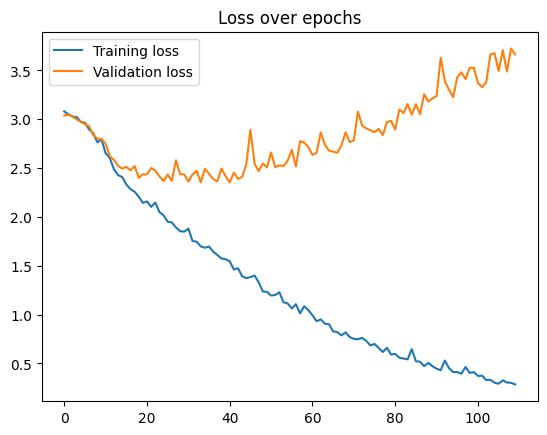

In [79]:
# visualize the loss during training
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

Inference

In [80]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

model = LandUseClassifier(num_classes=21)

model.load_state_dict(torch.load("3hidden_NN.ckpt"))


model.eval()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        prediction = torch.argmax(output, dim = 1)
        print(prediction)

<ipython-input-80-3c5aeb273af0>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("3hidden_NN.ckpt"))


tensor([ 0, 12,  0,  0,  2,  0,  2,  0,  7,  0,  2,  2,  2,  9,  0,  0,  0,  0,
        12, 12,  2, 12, 18, 17, 16, 11, 18,  2, 16,  1,  6, 16])
tensor([17, 15,  2,  1,  2, 18,  2,  9,  2,  2, 20,  2,  2,  2,  9, 12,  2,  2,
         2,  2,  2, 12,  3,  0,  2,  8, 18,  2, 20,  7, 20,  3])
tensor([ 3, 20,  3,  3, 20, 20, 16, 16, 16,  3, 12,  3,  3,  2,  2,  9,  1, 16,
        18,  4,  4,  3,  4, 12,  8, 19, 15, 12, 12, 19, 13, 19])
tensor([ 6, 12,  9,  4,  5,  2,  2,  2,  5,  5,  5,  5,  5,  5,  5,  5, 12, 12,
        12,  0,  5,  5, 12,  5,  2,  3,  2, 12, 12, 12,  8, 17])
tensor([ 8, 16, 19, 20, 12,  7, 11,  0, 12, 12,  8,  5, 18,  7,  0, 12,  9,  7,
         0,  9,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7])
tensor([ 8,  1,  2,  9,  8,  0,  8,  3, 20, 12, 20,  8,  2,  2, 12, 12,  8,  8,
        20,  5,  2, 12,  9,  8,  8,  2, 16, 20,  0,  2,  2,  9])
tensor([ 9,  9, 20, 16, 16, 16,  9,  9,  2,  4, 10, 10,  7, 10, 16, 12, 19, 12,
        16, 12, 10, 10,  4,  7, 10, 16,  7, 10, 20